<a href="https://colab.research.google.com/github/dhdphuong27/cham_diem_trac_nghiem_thptqg/blob/main/NoiDung2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages
import numpy as np
import argparse
import imutils
from imutils import contours
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
height = 3505
width = 2480
sheet_type = 2025
check_contour_detection = True
if sheet_type == 2025:
  exam_code_numbers = 4
else:
  exam_code_numbers = 3

In [ ]:
def preprocess_img(image):
	if image.ndim == 3 and image.shape[2] == 3:
			gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	elif image.ndim == 3 and image.shape[2] == 4:
			gray = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
	else:
			gray = image # No conversion needed, just assign it
	blurred = cv2.GaussianBlur(gray, (5, 5), 0)

	# apply Otsu's thresholding method to binarize the warped
	# piece of paper
	thresh = cv2.threshold(blurred, 0, 255,
		cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
	return thresh

In [ ]:
def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

def find_contours(thresh):
  # Find contours in the thresholded image
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  questionCnts = []

  # Create an array to store bounding boxes
  boundingBoxes = []

  # Loop over the contours and store their bounding boxes
  for c in cnts:
      (x, y, w, h) = cv2.boundingRect(c)
      ar = w / float(h)
      if (w >= 20*resolution_scale and h >= 20*resolution_scale and ar >= 0.9 and ar <= 1.1):
          boundingBoxes.append([x, y, x + w, y + h])
          questionCnts.append(c)

  # Convert the bounding boxes list to a numpy array
  boundingBoxes = np.array(boundingBoxes)

  # Apply non-maximum suppression
  filteredBoxes = non_max_suppression(boundingBoxes, overlapThresh=0.3)

  # Loop over the filtered boxes to keep only non-overlapping contours
  filteredContours = []
  for (startX, startY, endX, endY) in filteredBoxes:
      for c in questionCnts:
          (x, y, w, h) = cv2.boundingRect(c)
          if startX == x and startY == y and endX == x + w and endY == y + h:
              filteredContours.append(c)
              break
  return filteredContours


In [ ]:
def sort_contours(filteredContours, n):
	# sort the question contours top-to-bottom, then initialize
	tmp = contours.sort_contours(filteredContours,
		method="top-to-bottom")[0]

	sorted_ctrs = []

	for (q, i) in enumerate(range(len(filteredContours) - n, -1, -n)):
		sorted_ctrs.extend(contours.sort_contours(filteredContours[i:i + n])[0])
	return sorted_ctrs
#Here i sort top down - left to right


In [ ]:
def get_bubbled_indicies(sorted_ctrs,thresh):
  #Now I have sorted_ctrs, which contains all contours in sorted order
  #Now loop through every contours to check if that countour's innter area contains more black or white pixel
  #in order to determine where that box is checked
  bubbled = None
  bubbled_indices = []
  highest_non_bubbled_area = 500  #500 is the threshold, any printed number will be lower than this threshold
  # Loop over the sorted contours
  for (j, c) in enumerate(sorted_ctrs):
      # Construct a mask that reveals only the current "bubble" for the question
      mask = np.zeros(thresh.shape, dtype="uint8")
      cv2.drawContours(mask, [c], -1, 255, -1)

      # Apply the mask to the thresholded image, then count the number of non-zero pixels in the bubble area
      mask = cv2.bitwise_and(thresh, thresh, mask=mask)
      total = cv2.countNonZero(mask)
      # Append the index of the current bubble if it has non-zero pixels
      if total > highest_non_bubbled_area:
          bubbled_indices.append(j)
  return bubbled_indices

In [ ]:
import urllib
#Load image when using google colab
#req = urllib.request.urlopen('https://i.ibb.co/qF0WTR6/Bai-Lam-Trac-Nghiem-1.jpg')
#arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
#image = cv2.imdecode(arr, -1) # 'Load it as it is'

#load local image
image_path = "/content/4so.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#image = cv2.imread('BaiLamTracNghiem (1).jpg')

In [ ]:
height, width = image.shape[:2]
print(f"{height}x{width}")

resolution_scale = height/3505

3505x2480


In [ ]:
#Should use the basic specification of the original sheet, but now I just pull numbers out of my
#Because these type of sheets are scanned with the same resolusion, coordinates of these are fixed anyway
#Otherwise, can modify these numbers based on the original resolusion (2480x3508)

#mẫu tờ bài làm năm 2025
student_id_section = image[int(350*resolution_scale):int(1052*resolution_scale), int(1634*resolution_scale):int(2043*resolution_scale)]
exam_code_section = image[int(354*resolution_scale):int(1056*resolution_scale), int(2093*resolution_scale):int(2310*resolution_scale)]
part1_section = image[int(1244*resolution_scale):int(1887*resolution_scale), int(248*resolution_scale):int(2254*resolution_scale)]
part2_section = image[int(2074*resolution_scale):int(2319*resolution_scale), int(248*resolution_scale):int(2232*resolution_scale)]
part3_section = image[int(2530*resolution_scale):int(3231*resolution_scale), int(254*resolution_scale):int(2238*resolution_scale)]

In [ ]:
#Part 1 handle
height, width = part1_section.shape[:2]
column_width = width // 4
# Crop the image into 4 vertical columns
cropped_images = [part1_section[int(5*resolution_scale):int(625*resolution_scale), int(10*resolution_scale):int(446*resolution_scale)],
                  part1_section[int(5*resolution_scale):int(625*resolution_scale), int(520*resolution_scale):int(956*resolution_scale)],
                  part1_section[int(5*resolution_scale):int(625*resolution_scale), int(1030*resolution_scale):int(1466*resolution_scale)],
                  part1_section[int(5*resolution_scale):int(625*resolution_scale), int(1540*resolution_scale):int(1976*resolution_scale)]]

part1_section_horizontal = cv2.vconcat(cropped_images)
#Part 2 handle
cropped_images = [part2_section[int(0*resolution_scale):int(238*resolution_scale), int(62*resolution_scale):int(253*resolution_scale)],part2_section[int(0*resolution_scale):int(238*resolution_scale), int(255*resolution_scale):int(446*resolution_scale)],
                  part2_section[int(0*resolution_scale):int(238*resolution_scale), int(565*resolution_scale):int(756*resolution_scale)],part2_section[int(0*resolution_scale):int(238*resolution_scale), int(764*resolution_scale):int(955*resolution_scale)],
                  part2_section[int(0*resolution_scale):int(238*resolution_scale), int(1079*resolution_scale):int(1270*resolution_scale)],part2_section[int(0*resolution_scale):int(238*resolution_scale), int(1272*resolution_scale):int(1463*resolution_scale)],
                  part2_section[int(0*resolution_scale):int(238*resolution_scale), int(1590*resolution_scale):int(1781*resolution_scale)],part2_section[int(0*resolution_scale):int(238*resolution_scale), int(1786*resolution_scale):int(1977*resolution_scale)]]

part2_section_horizontal =  cv2.vconcat(cropped_images)

#Part 3 handle
height, width = part3_section.shape[:2]
column_width = width // 6
# Crop the image into 6 vertical columns
cropped_images = []
for i in range(6):  # Six columns
    x_start = i * column_width
    cropped_image = part3_section[:, x_start:x_start + column_width]
    cropped_images.append(cropped_image)
sign_and_decimal_sections = []
numbers_sections = []
for i in range(len(cropped_images)):
  sign_and_decimal_sections.append(cropped_images[i][int(0*resolution_scale):int(145*resolution_scale),:])
  numbers_sections.append(cropped_images[i][int(145*resolution_scale):,:])

sign_and_decimal_horizontal = cv2.vconcat(sign_and_decimal_sections)
numbers_horizontal = cv2.vconcat(numbers_sections)

In [ ]:
#Demo detection result
#part3_demo = part3_section.copy()
#cv2.drawContours(part3_demo, find_contours(preprocess_img(part3_demo)), -1, (0, 255, 0), 2)
#combined_image = cv2.vconcat([part3_section, part3_demo])
#cv2_imshow(combined_image)

There are 80 circle detected in this section


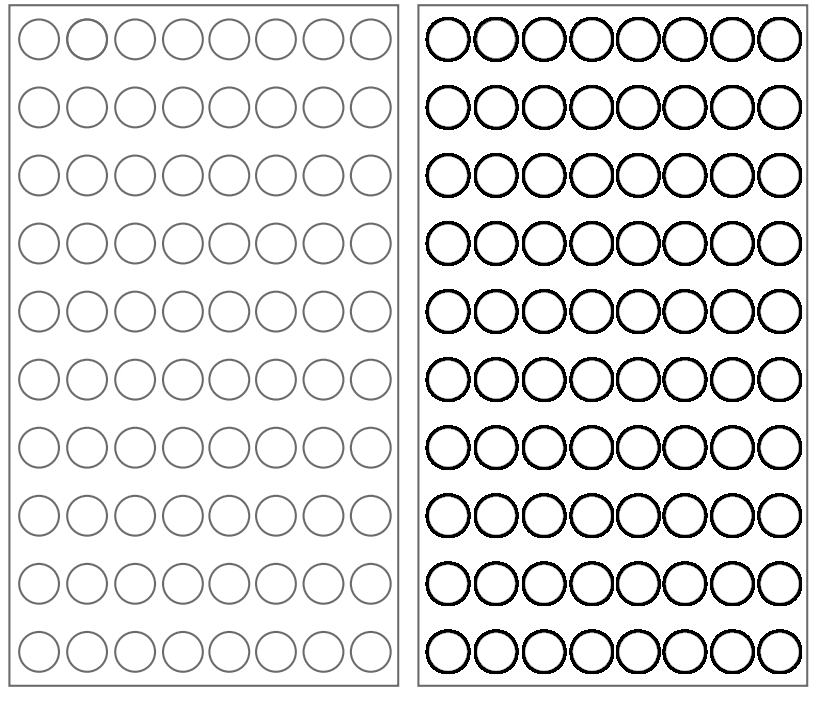

[]
Student id: NoneNoneNoneNoneNoneNoneNoneNone


In [ ]:
#Scan for Student ID
thresh = preprocess_img(student_id_section)
filteredContours = find_contours(thresh)
sorted_ctrs = sort_contours(filteredContours,6)
bubbled_indices = get_bubbled_indicies(sorted_ctrs,thresh)

if check_contour_detection == True:
  print(f"There are {len(filteredContours)} circle detected in this section")
  student_id_demo = student_id_section.copy()
  cv2.drawContours(student_id_demo, find_contours(preprocess_img(student_id_demo)), -1, (0, 255, 0), 2)
  combined_image = cv2.hconcat([student_id_section, student_id_demo])
  cv2_imshow(combined_image)

#now handle bubbled_indices, which varies depend on which section it is
#bubbled_indices now contains the indices of the contours that are bubbled
print(bubbled_indices)
#I just need make a "little modification"
#Ex pic is [1, 3, 4, 6, 11, 14]
# if the number is 1, 1 < 6*(n+1) (n here is 0), then it's number 0 in the second (1+1) position  (n is row, indicate the number)
#60 is bubbled => 6th digit is 9
#59 is bubbled => 5th digit is 9
#55 is bubbled => 1st digit is 9
student_id = [None]*8
for i in (bubbled_indices):
  number = i//8
  position = i%8
  student_id[position] = number
str_id = ''
for i in student_id:
  str_id += str(i)
print("Student id: " +str_id)

There are 40 circle detected in this section


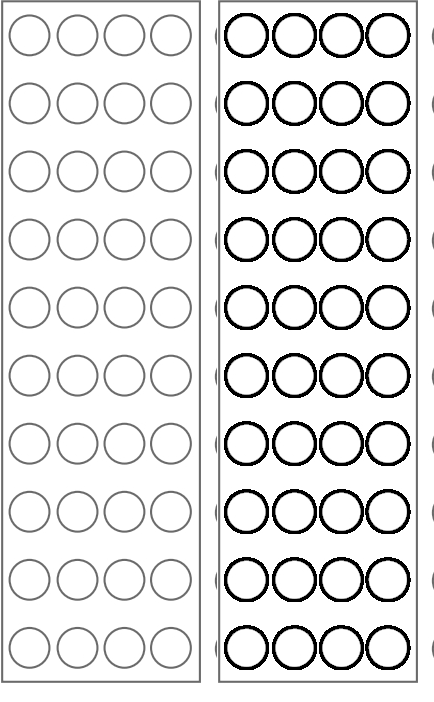

[]
Exam code: NoneNoneNoneNone


In [ ]:
#Scan for exam code

thresh = preprocess_img(exam_code_section)
filteredContours = find_contours(thresh)
sorted_ctrs = sort_contours(filteredContours,3)  #there are 3 digits in exam code
bubbled_indices = get_bubbled_indicies(sorted_ctrs,thresh)

if check_contour_detection == True:
  print(f"There are {len(filteredContours)} circle detected in this section")
  exam_code_demo = exam_code_section.copy()
  cv2.drawContours(exam_code_demo, find_contours(preprocess_img(exam_code_demo)), -1, (0, 255, 0), 2)
  combined_image = cv2.hconcat([exam_code_section, exam_code_demo])
  cv2_imshow(combined_image)

#now handle bubbled_indices, which varies depend on which section it is
print(bubbled_indices)
exam_code = [None]*exam_code_numbers
for i in (bubbled_indices):
  number = i//exam_code_numbers
  position = i%exam_code_numbers
  exam_code[position] = number
str_exam_code = ''
for i in exam_code:
  str_exam_code += str(i)
print("Exam code: " +str_exam_code)

In [ ]:
#Part 1 can be cut into 4 section, then extend it to the bottom so that we only need to process once
#Part 2 make a function that process each question (1-8), like a mini version of part 1
#Part 2 is similar to student id and exam code section, just with "a little bit" more effort
#   on decimal point's position and negative sign

There are 160 circle detected in this section


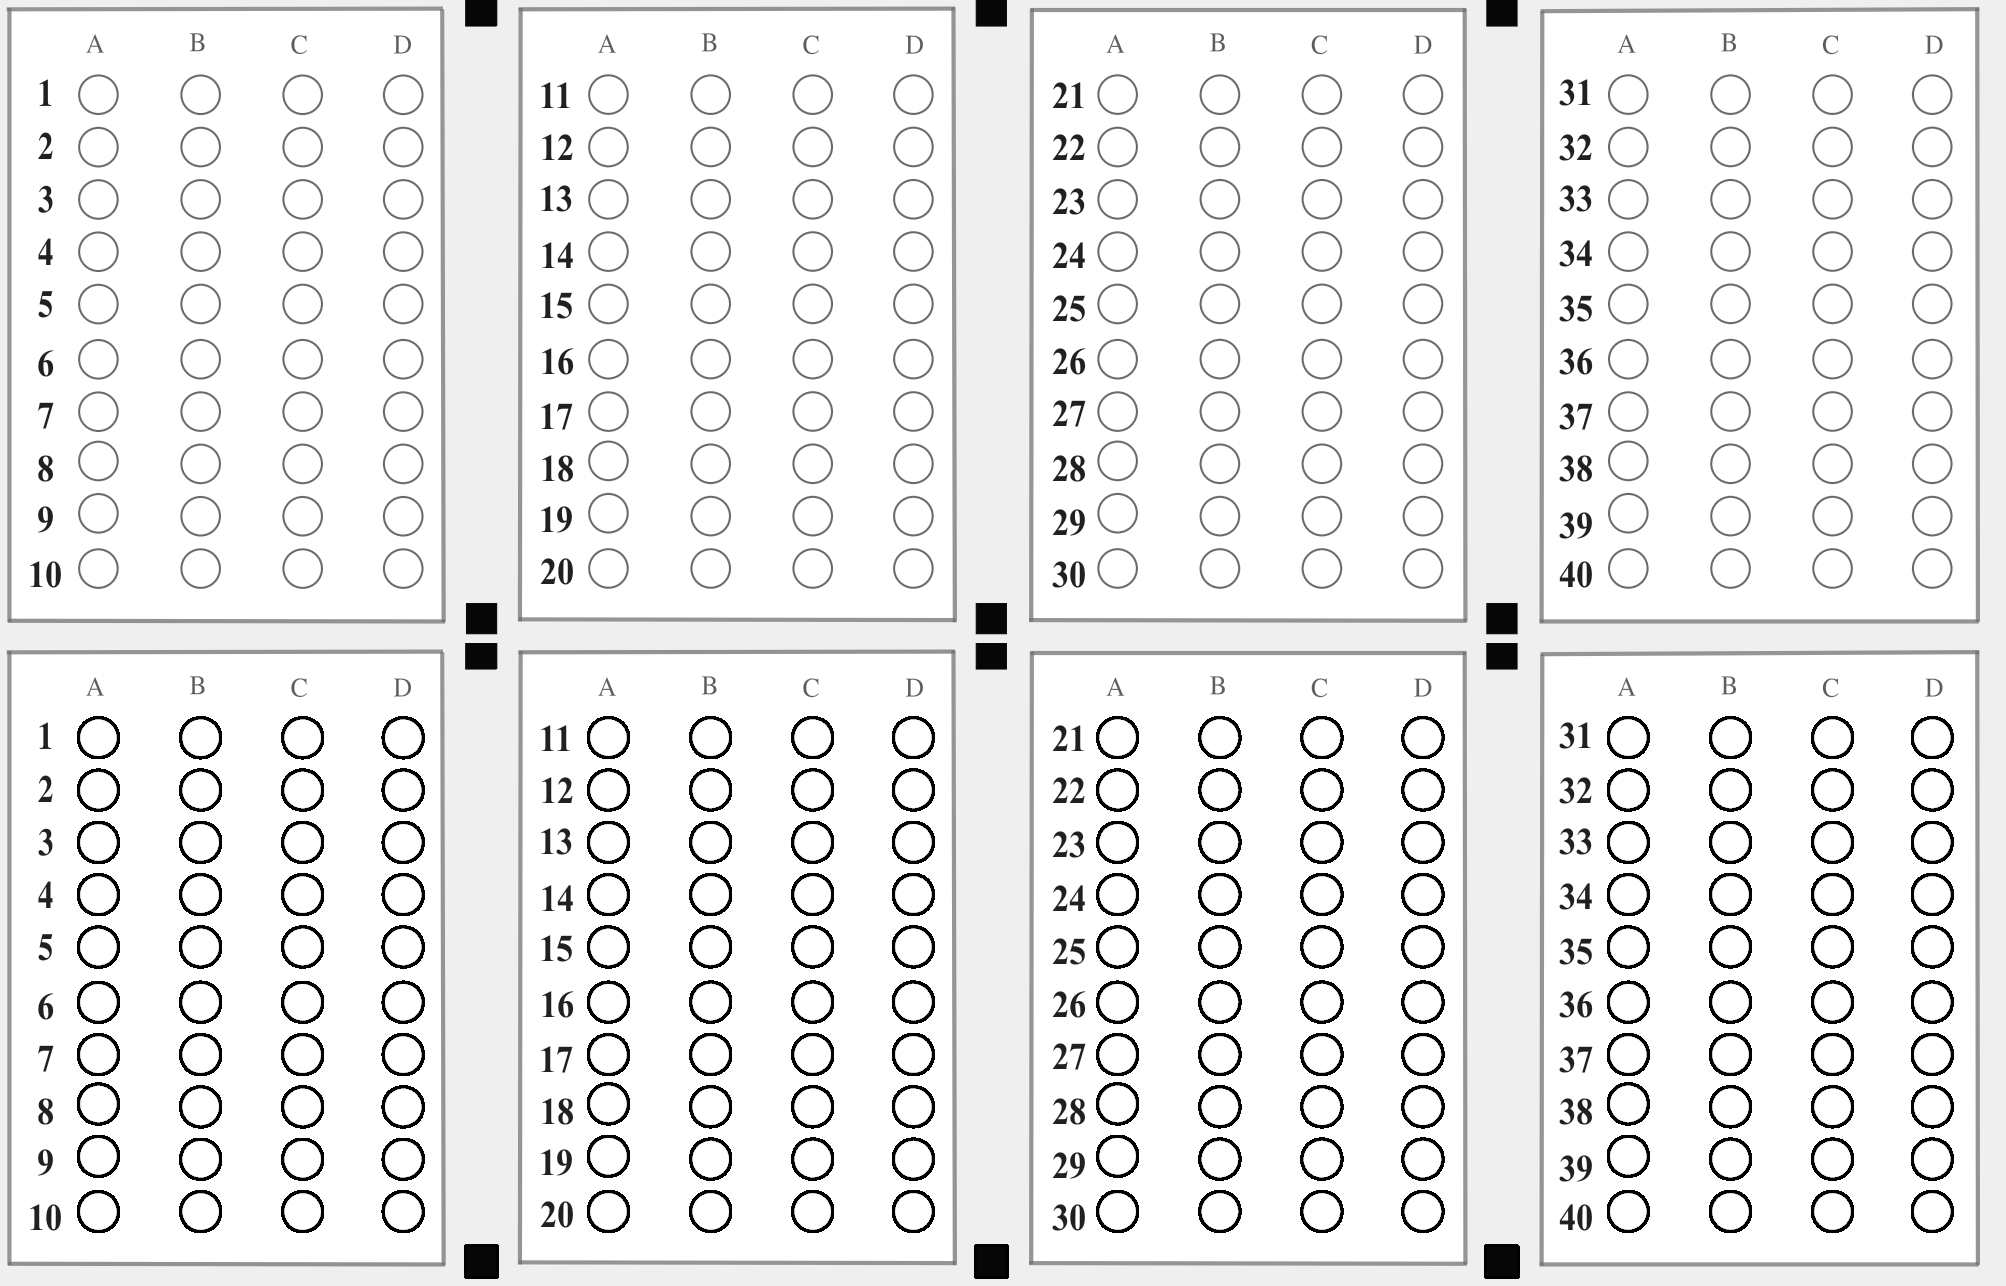

[]
Student's answers for part one is: 
{}


In [ ]:
#Scan part 1  part1_section_horizontal
thresh = preprocess_img(part1_section_horizontal)
filteredContours = find_contours(thresh)
sorted_ctrs = sort_contours(filteredContours,4)  #there are 4 answers each row
bubbled_indices = get_bubbled_indicies(sorted_ctrs,thresh)


if check_contour_detection == True:
  print(f"There are {len(filteredContours)} circle detected in this section")
  part1_demo = part1_section.copy()
  cv2.drawContours(part1_demo, find_contours(preprocess_img(part1_demo)), -1, (0, 255, 0), 2)
  combined_image = cv2.vconcat([part1_section, part1_demo])
  cv2_imshow(combined_image)

#cv2.drawContours(part1_section_horizontal, [sorted_ctrs[i] for i in bubbled_indices], -1, (0, 255, 0), 2)
#cv2_imshow(part1_section_horizontal)

#Now handle bubbled_indices, which varies depend on which section it is
#Add one to make calculation easier
bubbled_indices = [x + 1 for x in bubbled_indices]
#Create a dictionary with 40 entries, each key is its index and value (answers) is an empty list
#I'm using list because students may choose many answers, which we remove all later
print(bubbled_indices)
answers = {i + 1: [] for i in range(40)}
for i in (bubbled_indices):
  answer = i%4 if i%4!=0 else 4
  alphabet_answer = chr(64+answer)
  index = i//4 if i%4==0 else i//4+1
  answers[index].append(alphabet_answer)

part1_answers = {k: v for k, v in answers.items() if len(v) == 1}
print("Student's answers for part one is: ")
print(part1_answers)


There are 64 circle detected in this section


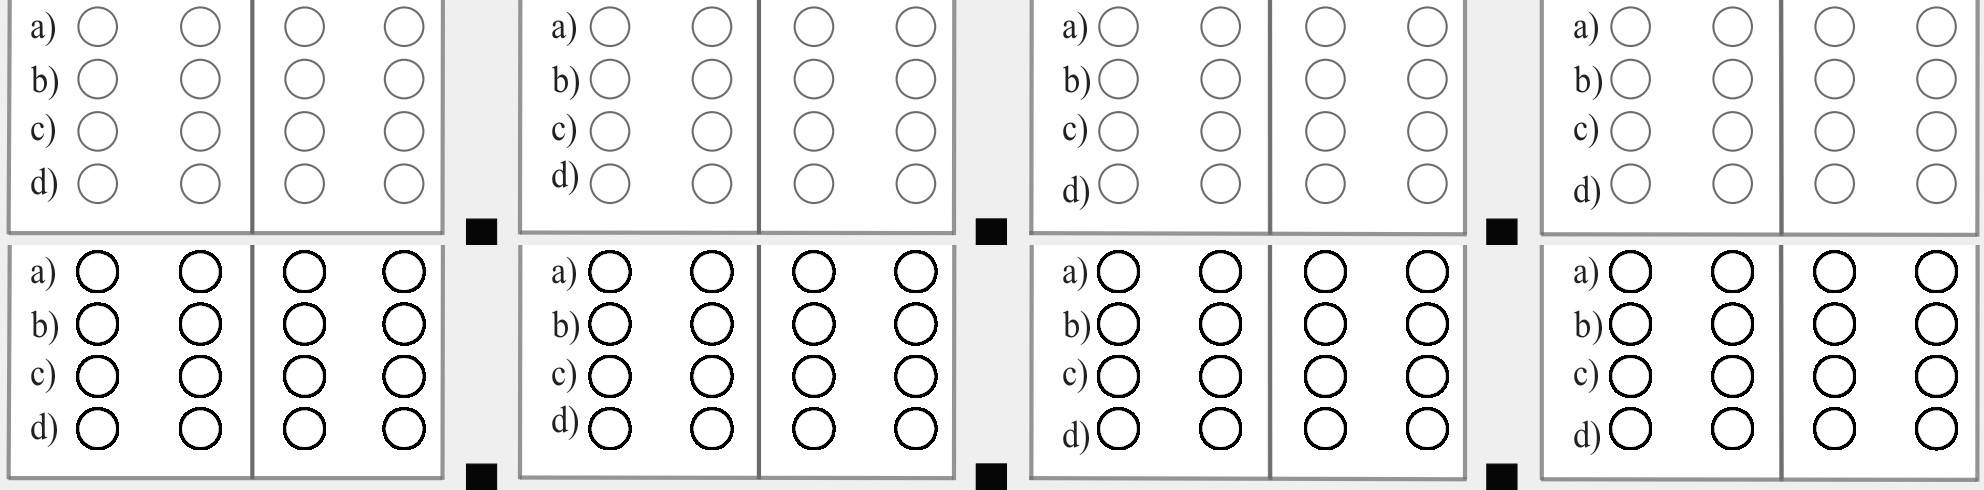

[]
Student's answers for part two is: 
{}


In [ ]:
#Scan part 2 part2_section_horizontal
thresh = preprocess_img(part2_section_horizontal)
filteredContours = find_contours(thresh)
sorted_ctrs = sort_contours(filteredContours,2)  #there are 2 answers each row
bubbled_indices = get_bubbled_indicies(sorted_ctrs,thresh)

if check_contour_detection == True:
  print(f"There are {len(filteredContours)} circle detected in this section")
  part2_demo = part2_section.copy()
  cv2.drawContours(part2_demo, find_contours(preprocess_img(part2_demo)), -1, (0, 255, 0), 2)
  combined_image = cv2.vconcat([part2_section, part2_demo])
  cv2_imshow(combined_image)


bubbled_indices = [x + 1 for x in bubbled_indices]
answers = {i + 1: [] for i in range(32)}
print(bubbled_indices)
for i in (bubbled_indices):
  answer = True if i%2!=0 else False
  index = i//2 if i%2==0 else i//2+1
  answers[index].append(answer)
answers = {k: v for k, v in answers.items() if len(v) == 1}
#rearrange dictionary
part2_answers = {}
# Group size
group_size = 4
# Grouping logic
for i in range(0, len(answers), group_size):
    group_index = i // group_size + 1
    part2_answers[group_index] = {
        'A': answers.get(i + 1, []),
        'B': answers.get(i + 2, []),
        'C': answers.get(i + 3, []),
        'D': answers.get(i + 4, [])
    }
print("Student's answers for part two is: ")
print(part2_answers)

There are 258 circle detected in this section


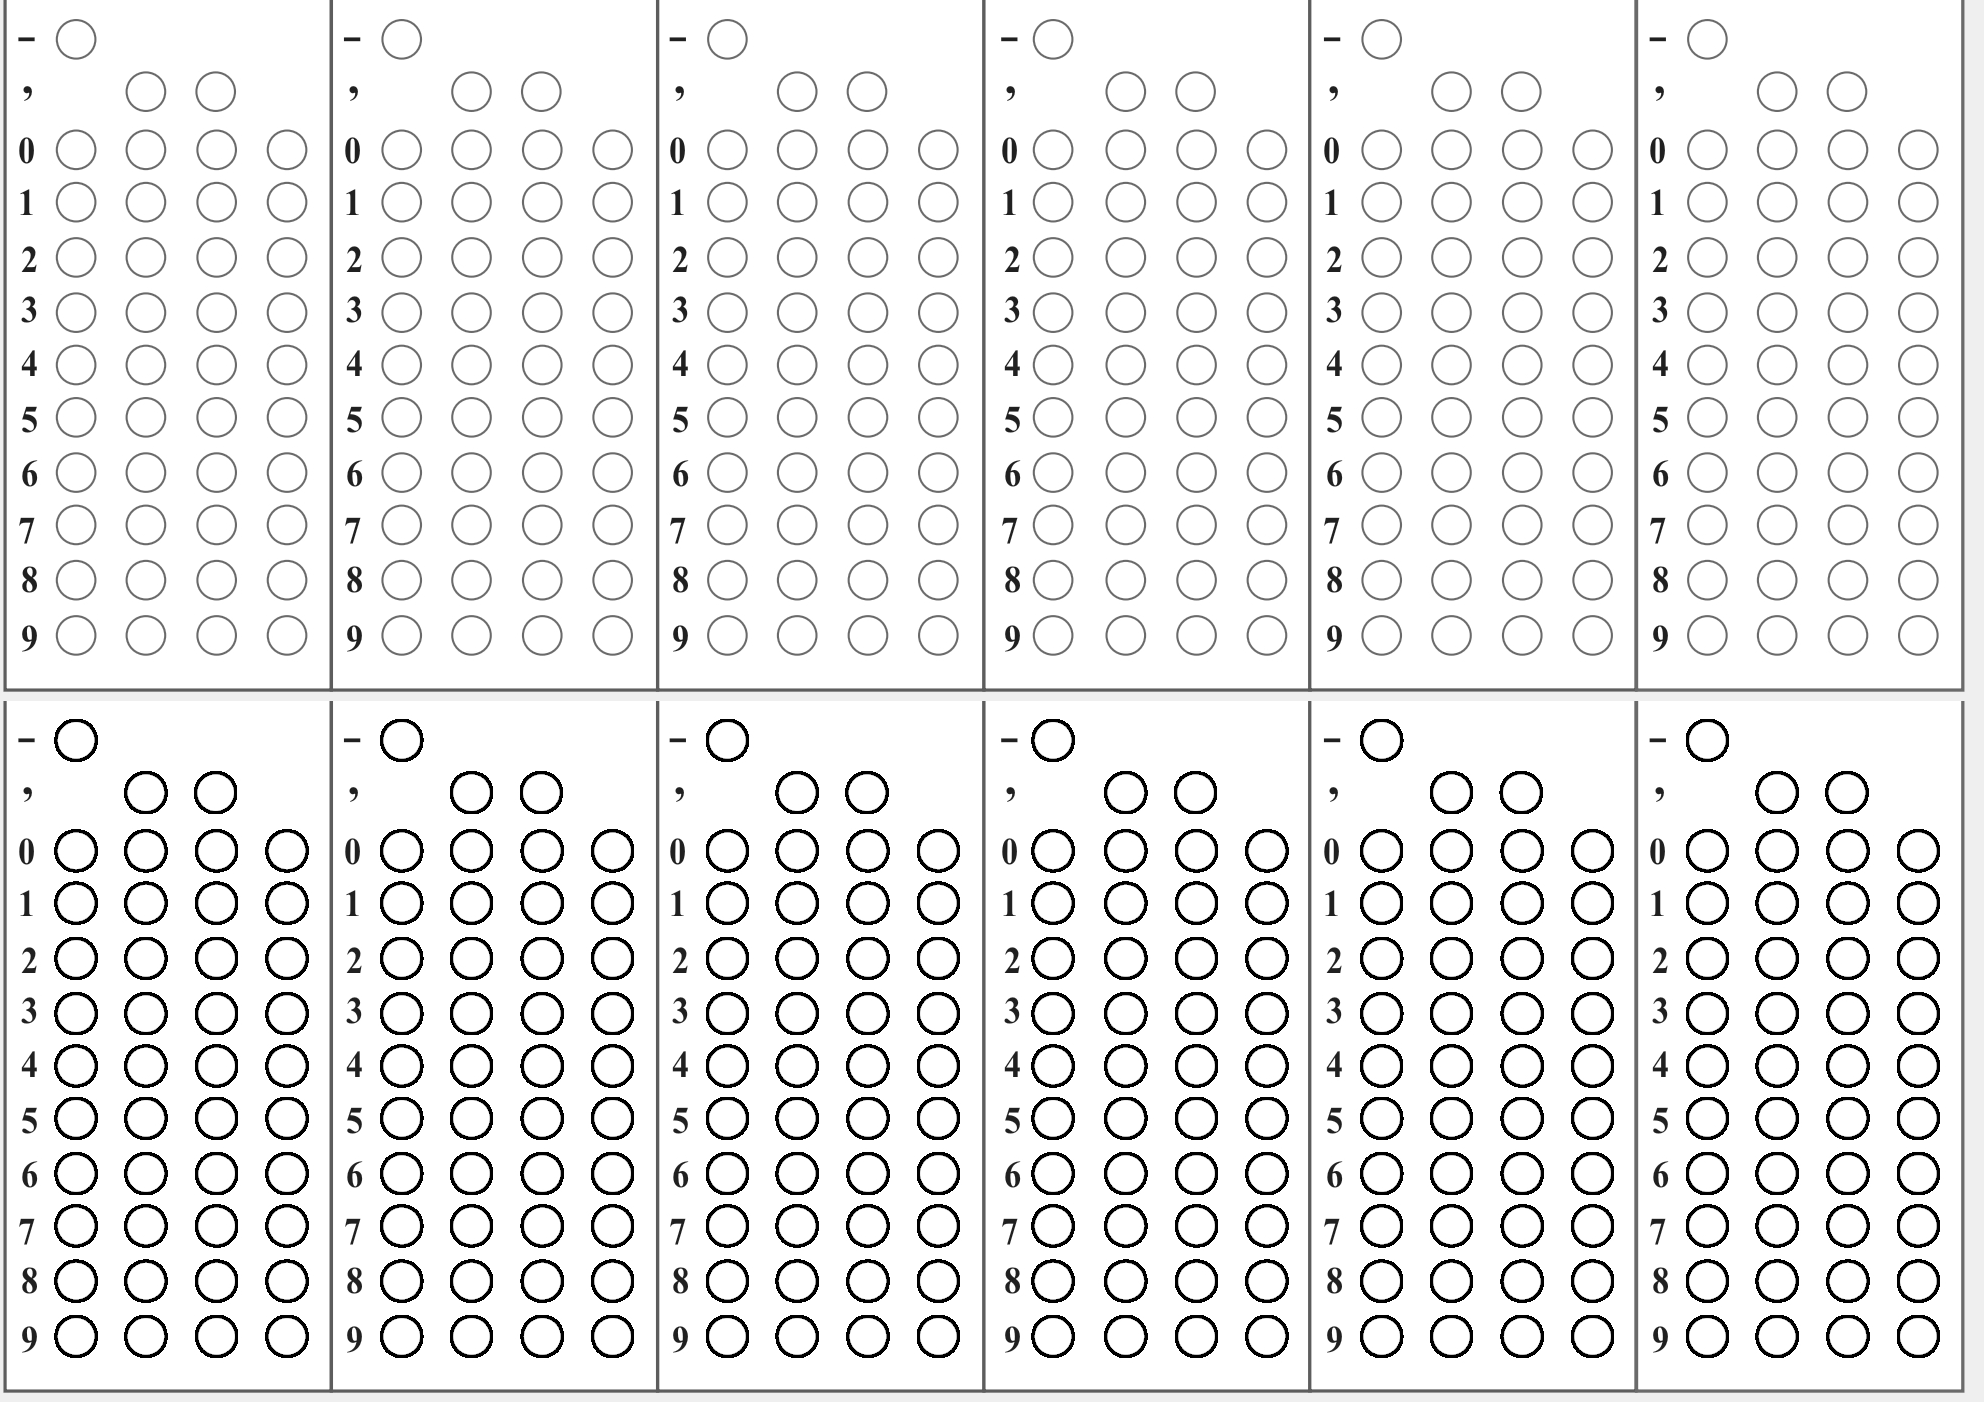

In [ ]:
if check_contour_detection == True:
  part3_demo = part3_section.copy()
  filteredContours = find_contours(preprocess_img(part3_demo))
  print(f"There are {len(filteredContours)} circle detected in this section")
  cv2.drawContours(part3_demo, filteredContours, -1, (0, 255, 0), 2)
  combined_image = cv2.vconcat([part3_section, part3_demo])
  cv2_imshow(combined_image)

In [ ]:
#Scan part 3 sign_and_decimal_horizontal and numbers_horizontal

#sign_and_decimal_horizontal
thresh = preprocess_img(sign_and_decimal_horizontal)
filteredContours = find_contours(thresh)
sorted_ctrs = sort_contours(filteredContours,3)  #there are 2 answers each row
bubbled_indices = get_bubbled_indicies(sorted_ctrs,thresh)


#cv2.drawContours(sign_and_decimal_horizontal, sorted_ctrs, -1, (0, 255, 0), 2)


# Create a dictionary with keys from 1 to 6, and each value is a list of five None elements
print(bubbled_indices)
part3_answers_dict = {i: [""] * 4 for i in range(1, 7)}
part3_answers_sign_dict = {i: "" for i in range(1, 7)}
for i in (bubbled_indices):
  index = i//3 if i%3==0 else i//3+1
  if i%3==0:
    part3_answers_sign_dict[index+1] = '-'
  else:
    part3_answers_dict[index][i%3] = ','

print(part3_answers_sign_dict)
print(part3_answers_dict)


[]
{1: '', 2: '', 3: '', 4: '', 5: '', 6: ''}
{1: ['', '', '', ''], 2: ['', '', '', ''], 3: ['', '', '', ''], 4: ['', '', '', ''], 5: ['', '', '', ''], 6: ['', '', '', '']}


In [ ]:

#numbers_horizontal
thresh = preprocess_img(numbers_horizontal)
filteredContours = find_contours(thresh)
sorted_ctrs = sort_contours(filteredContours,4)  #there are 4 answers each row
bubbled_indices = get_bubbled_indicies(sorted_ctrs,thresh)

#cv2.drawContours(numbers_horizontal,sorted_ctrs, -1, (0, 255, 0), 2)
print(bubbled_indices)
for i in (bubbled_indices):
  index = i//40
  #215//40 = 5, 215-5*40
  index_in_question = i-index*40
  number = index_in_question//4
  position = i%4
  part3_answers_dict[index+1][position] = str(number)

part3_answers = {i: "" for i in range(1, 7)}
for i in range(1,7):
  answer = part3_answers_sign_dict[i]+"".join(part3_answers_dict[i])
  part3_answers[i] = answer
print("Student's answer for part 3 is: ")
print(part3_answers)


[]
Student's answer for part 3 is: 
{1: '', 2: '', 3: '', 4: '', 5: '', 6: ''}


In [ ]:
#Print out result with the correct format

print("SBD: ", str_id)
print("Mã đề thi: ", str_exam_code)
print("Phần 1: ")
for key,value in part1_answers.items():
  print(key,end='')
  print(value[0])
print("Phần 2: ")
for key,value in part2_answers.items():
  for key2,value2 in value.items():
    print(key,end='')
    print(key2,end=': ')
    print('Đúng' if value2[0] else 'Sai')
print("Phần 3: ")
for key,value in part3_answers.items():
  print(key,end=': ')
  print(value)


SBD:  NoneNoneNoneNoneNoneNoneNoneNone
Mã đề thi:  NoneNoneNoneNone
Phần 1: 
Phần 2: 
Phần 3: 
1: 
2: 
3: 
4: 
5: 
6: 


In [ ]:
# Save all scanned result into 1 dictionary
arr = [] #to save multiple students' result
dic = {'SBD':str_id,'MaDe':str_exam_code,'Phan1':part1_answers,'Phan2':part2_answers,'Phan3':part3_answers}
result = dic.copy()
del result['SBD']
del result['MaDe']
arr.append(dic)
for i in arr:
  score = 0
  for key,value in i['Phan1'].items():
    if result['Phan1'][key][0] == value[0]:
      score+=0.25
  for key,value in i['Phan2'].items():
    num_of_correct_answers = 0
    for key2,value2 in value.items():
      if result['Phan2'][key][key2][0] == value2[0]:
        num_of_correct_answers+=1
    if num_of_correct_answers == 1:
        score+=0.1
    if num_of_correct_answers == 2:
        score+=0.25
    if num_of_correct_answers == 3:
        score+=0.5
    if num_of_correct_answers == 4:
        score+=1
  for key,value in i['Phan3'].items():
    if result['Phan3'][key] == value:
      score+=0.5
print(score)


3.0


# Công cụ chấm điểm bài thi THPT Quốc gia 2025

Đây là một phần của công cụ tự động chấm điểm bài thi trắc nghiệm cho Kỳ thi Tốt nghiệp Trung học Phổ thông Quốc gia năm 2025 tại Việt Nam.

Dự án này sử dụng các kỹ thuật xử lý ảnh với OpenCV để:

- **Nhận dạng thông tin thí sinh:** Trích xuất số báo danh (SBD) và mã đề thi từ ảnh chụp bài làm.
- **Chấm điểm tự động:** Đọc và chấm điểm các phần trắc nghiệm (Phần 1, Phần 2, Phần 3) dựa trên các ô được tô (bubbled).
- **Xử lý các dạng câu hỏi khác nhau:** Hỗ trợ các dạng câu hỏi trắc nghiệm nhiều lựa chọn, đúng/sai và điền số.

**Tính năng chính:**

- Sử dụng OpenCV và các thư viện liên quan (`numpy`, `imutils`).
- Áp dụng các bước tiền xử lý ảnh như chuyển sang ảnh xám, làm mờ và phân ngưỡng Otsu.
- Phát hiện và sắp xếp các ô đáp án (contours).
- Xác định các ô được tô sáng (bubbled indices) dựa trên số lượng pixel khác không.
- Trích xuất và định dạng kết quả cho từng phần của bài thi.

**Yêu cầu:**

- Python 3.x
- OpenCV
- numpy
- imutils

**Cách sử dụng:**

(Hướng dẫn chi tiết về cách cài đặt thư viện và chạy mã sẽ được bổ sung sau.)

**Lưu ý:**

- Mã nguồn hiện tại là một phần của hệ thống chấm điểm hoàn chỉnh.
- Các tham số như tọa độ cắt ảnh (cropping coordinates) được điều chỉnh dựa trên cấu trúc phôi giấy thi cụ thể và có thể cần điều chỉnh nếu sử dụng các phôi giấy khác.
- Việc xử lý các trường hợp đặc biệt như tô nhầm, tô nhiều đáp án, hoặc các vấn đề về chất lượng ảnh có thể cần các cải tiến bổ sung.

**Đóng góp:**

Mọi đóng góp để cải thiện công cụ này đều được hoan nghênh!